## Gas Prices Model - Noah Lombardozzi

This ANN model leverages the pytrends API and EIA historical records to predict the average price of retail gasoline in Texas for a given week. The following code retrieves data from relevant APIs, uses SQL to create rolling averages of the numeric variables, and preprocesses the data before training the ANN. Because the ANN consists of only a relatively small number of parameters, various test-training splits are examined in an attempt to derive the smallest-yet-accurate training sample. In the future, the model will accept stock market benchmark data as an input.

The takeaway from this "first draft" of a model is that the rolling averages of Google search and price data performs best at predicting middle of the road gas prices, and performs less well at predicting very high and very low gas prices. But - there's still much more data to leverage, and so I'm hopeful that the accuracy can be improved!

Long-term, I'd like to add in a bit of code to send myself an email at the start of each week with the model's predicitions!

In [1]:
import numpy
import pandas
import pytrends
import yfinance #In the future, this model will incorporate exchange-based benchmarks as features. 
from pytrends.request import TrendReq
import sqlalchemy
from sqlalchemy import create_engine
import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import csv
import os
import requests
import json
import datetime


In [6]:
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ["futures", "inflation", "stock market", "gas prices", "gas"]
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='US-TX', gprop='')
google = pytrends.interest_over_time()
google = google.reset_index()
google = google.rename(columns={'date':'week', 'stock market':'stock_market', 'gas prices':'gas_prices'})
    #google['week'] = pandas.to_datetime(response['week'], infer_datetime_format=True)
google = pandas.DataFrame(google).reset_index()
google.drop(['index'], axis=1, inplace=True)

dt = datetime.datetime.now().strftime('%Y-%m-%d')
api_url = f"https://api.eia.gov/v2/petroleum/pri/gnd/data/?api_key=rK6j0LBWsf18CKcGktriSuqgMPgzTHUwgN0JgmDd&frequency=weekly&data[0]=value&facets[duoarea][]=STX&facets[product][]=EPMR&start=2018-01-10&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000"
response = requests.get(api_url)
res = response.json()
response = pandas.json_normalize(res, ['response','data'])
response.drop(['duoarea', 'area-name', 'product', 'process-name', 'series', 'series-description', 'units', 'product-name', 'process'], axis=1, inplace=True)
response['week'] = response['period']
response['price'] = response['value']
response.drop(['period', 'value'], axis=1, inplace=True)
response['week'] = pandas.to_datetime(response['week'], infer_datetime_format=True)
response['week'] = response['week'] - pandas.Timedelta("1 days")
gas_data = pandas.DataFrame(response).reset_index()
gas_data.drop(['index'], axis=1, inplace=True)

df = gas_data.merge(google, on='week')
df.drop(['isPartial'], axis=1, inplace=True)
df.tail()

,week,price,futures,inflation,stock_market,gas_prices,gas
255,2022-12-18,2.551,2,2,3,1,39
256,2022-12-25,2.619,2,2,4,2,34
257,2023-01-01,2.837,2,2,3,2,32
258,2023-01-08,2.824,2,3,3,2,35
259,2023-01-15,2.925,2,3,3,2,34


This particular piece of code is still under development and will be used to request needed data from the APIs each week


def scrape_data():
  
  def get_google():
    #dt = datetime.datetime.now().strftime('%Y-%m-%d')
    #td = datetime.datetime.today() - datetime.timedelta(days=1)
    #td= td.strftime('%Y-%m-%d')
    pytrends = TrendReq(hl='en-US', tz=360)
    kw_list = ["futures", "inflation", "stock market", "gas prices", "gas"]
    pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='US-TX', gprop='')
    google = pytrends.interest_over_time()
    google = google.reset_index()
    google = google.rename(columns={'date':'week', 'stock market':'stock_market', 'gas prices':'gas_prices'})
    #google['week'] = pandas.to_datetime(response['week'], infer_datetime_format=True)
    this_week = pandas.DataFrame(google.iloc[-1,:]).transpose().reset_index()
    this_week.drop(['index'], axis=1, inplace=True)
    return this_week #google 
  
  def get_gas_data():
      dt = datetime.datetime.now().strftime('%Y-%m-%d')
      api_url = f"https://api.eia.gov/v2/petroleum/pri/gnd/data/?api_key=rK6j0LBWsf18CKcGktriSuqgMPgzTHUwgN0JgmDd&frequency=weekly&data[0]=value&facets[duoarea][]=STX&facets[product][]=EPMR&end=2023-01-09&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000"
      response = requests.get(api_url)
      res = response.json()
      response = pandas.json_normalize(res, ['response','data'])
      response.drop(['duoarea', 'area-name', 'product', 'process-name', 'series', 'series-description', 'units', 'product-name', 'process'], axis=1, inplace=True)
      response['week'] = response['period']
      response['price'] = response['value']
      response.drop(['period', 'value'], axis=1, inplace=True)
      response['week'] = pandas.to_datetime(response['week'], infer_datetime_format=True)
      response['week'] = response['week'] - pandas.Timedelta("1 days")
      gas_data = pandas.DataFrame(response.iloc[-1,:]).transpose().reset_index()
      gas_data.drop(['index'], axis=1, inplace=True)
      return gas_data
    
  def merge_google_gasoline(df, gas_df):  
    df = df.merge(gas_df, on='week')
    return df
  
  google = get_google()
  gas = get_gas_data()
  df = merge_google_gasoline(google, gas)
  
  return df

df = scrape_data()
df.head()



In [7]:
engine = create_engine('sqlite:///C:\\Users\\lomba\Downloads\\sqlite-tools-win32-x86-3400000\\sqlite-tools-win32-x86-3400000\\gasprices.db')          
df.to_sql('gas', con = engine, if_exists='replace')

%reload_ext sql
%sql sqlite:///C:\\Users\\lomba\Downloads\\sqlite-tools-win32-x86-3400000\\sqlite-tools-win32-x86-3400000\\gasprices.db

In [8]:
%%sql
SELECT * FROM gas
LIMIT 10

 * sqlite:///C:\\Users\\lomba\Downloads\\sqlite-tools-win32-x86-3400000\\sqlite-tools-win32-x86-3400000\\gasprices.db
Done.


index,week,price,futures,inflation,stock_market,gas_prices,gas
0,2018-01-28 00:00:00.000000,2.333,2,1,5,1,27
1,2018-02-04 00:00:00.000000,2.344,4,2,14,1,26
2,2018-02-11 00:00:00.000000,2.312,2,1,4,1,27
3,2018-02-18 00:00:00.000000,2.255,2,1,3,1,28
4,2018-02-25 00:00:00.000000,2.235,2,1,4,1,30
5,2018-03-04 00:00:00.000000,2.282,2,1,3,1,29
6,2018-03-11 00:00:00.000000,2.285,2,1,2,1,28
7,2018-03-18 00:00:00.000000,2.307,2,1,4,1,33
8,2018-03-25 00:00:00.000000,2.379,2,1,4,1,30
9,2018-04-01 00:00:00.000000,2.417,3,1,4,1,31


In [9]:
%%sql
SELECT week, price, avg(price) OVER(ORDER BY week ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) price_rolling_average3,
avg(price) OVER(ORDER BY week ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) price_rolling_average5,
avg(price) OVER(ORDER BY week ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) price_rolling_average10,
avg(price) OVER(ORDER BY week ROWS BETWEEN 14 PRECEDING AND CURRENT ROW) price_rolling_average15,
avg(price) OVER(ORDER BY week ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) price_rolling_average20,
futures, inflation, stock_market, gas_prices, gas,
LAG(price, 1) OVER(ORDER BY week) last_price
FROM gas
LIMIT 10	

 * sqlite:///C:\\Users\\lomba\Downloads\\sqlite-tools-win32-x86-3400000\\sqlite-tools-win32-x86-3400000\\gasprices.db
Done.


week,price,price_rolling_average3,price_rolling_average5,price_rolling_average10,price_rolling_average15,price_rolling_average20,futures,inflation,stock_market,gas_prices,gas,last_price
2018-01-28 00:00:00.000000,2.333,2.333,2.333,2.333,2.333,2.333,2,1,5,1,27,None
2018-02-04 00:00:00.000000,2.344,2.3385,2.3385,2.3385,2.3385,2.3385,4,2,14,1,26,2.333
2018-02-11 00:00:00.000000,2.312,2.3296666666666663,2.3296666666666663,2.3296666666666663,2.3296666666666663,2.3296666666666663,2,1,4,1,27,2.344
2018-02-18 00:00:00.000000,2.255,2.303666666666666,2.311,2.311,2.311,2.311,2,1,3,1,28,2.312
2018-02-25 00:00:00.000000,2.235,2.2673333333333328,2.2958,2.2958,2.2958,2.2958,2,1,4,1,30,2.255
2018-03-04 00:00:00.000000,2.282,2.257333333333333,2.2855999999999996,2.2935,2.2935,2.2935,2,1,3,1,29,2.235
2018-03-11 00:00:00.000000,2.285,2.2673333333333328,2.2738,2.2922857142857143,2.2922857142857143,2.2922857142857143,2,1,2,1,28,2.282
2018-03-18 00:00:00.000000,2.307,2.2913333333333328,2.2728,2.2941249999999997,2.2941249999999997,2.2941249999999997,2,1,4,1,33,2.285
2018-03-25 00:00:00.000000,2.379,2.323666666666666,2.2976,2.3035555555555556,2.3035555555555556,2.3035555555555556,2,1,4,1,30,2.307
2018-04-01 00:00:00.000000,2.417,2.367666666666666,2.3340000000000005,2.3149,2.3149,2.3149,3,1,4,1,31,2.379


In [10]:
df = pandas.read_sql('''SELECT week, price, LAG(price, 1) OVER(ORDER BY week) last_price, avg(price) OVER(ORDER BY week ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) price_rolling_average3,
avg(price) OVER(ORDER BY week ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) price_rolling_average5,
avg(price) OVER(ORDER BY week ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) price_rolling_average10,
avg(price) OVER(ORDER BY week ROWS BETWEEN 14 PRECEDING AND CURRENT ROW) price_rolling_average15,
avg(price) OVER(ORDER BY week ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) price_rolling_average20,
futures, 
avg(futures) OVER(ORDER BY week ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) futures_rolling_average3,
avg(futures) OVER(ORDER BY week ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) futures_rolling_average5,
avg(futures) OVER(ORDER BY week ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) futures_rolling_average10,
avg(futures) OVER(ORDER BY week ROWS BETWEEN 14 PRECEDING AND CURRENT ROW) futures_rolling_average15,
avg(futures) OVER(ORDER BY week ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) futures_rolling_average20,
inflation,
avg(inflation) OVER(ORDER BY week ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) inflation_rolling_average3,
avg(inflation) OVER(ORDER BY week ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) inflation_rolling_average5,
avg(inflation) OVER(ORDER BY week ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) inflation_rolling_average10,
avg(inflation) OVER(ORDER BY week ROWS BETWEEN 14 PRECEDING AND CURRENT ROW) inflation_rolling_average15,
avg(inflation) OVER(ORDER BY week ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) inflation_rolling_average20, 
stock_market, 
avg(stock_market) OVER(ORDER BY week ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) stock_market_rolling_average3,
avg(stock_market) OVER(ORDER BY week ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) stock_market_rolling_average5,
avg(stock_market) OVER(ORDER BY week ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) stock_market_rolling_average10,
avg(stock_market) OVER(ORDER BY week ROWS BETWEEN 14 PRECEDING AND CURRENT ROW) stock_market_rolling_average15,
avg(stock_market) OVER(ORDER BY week ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) stock_market_rolling_average20,
gas_prices, 
avg(gas_prices) OVER(ORDER BY week ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) gas_prices_rolling_average3,
avg(gas_prices) OVER(ORDER BY week ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) gas_prices_rolling_average5,
avg(gas_prices) OVER(ORDER BY week ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) gas_prices_rolling_average10,
avg(gas_prices) OVER(ORDER BY week ROWS BETWEEN 14 PRECEDING AND CURRENT ROW) gas_prices_rolling_average15,
avg(gas_prices) OVER(ORDER BY week ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) gas_prices_rolling_average20,
gas,
avg(gas) OVER(ORDER BY week ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) gas_rolling_average3,
avg(gas) OVER(ORDER BY week ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) gas_rolling_average5,
avg(gas) OVER(ORDER BY week ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) gas_rolling_average10,
avg(gas) OVER(ORDER BY week ROWS BETWEEN 14 PRECEDING AND CURRENT ROW) gas_rolling_average15,
avg(gas) OVER(ORDER BY week ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) gas_rolling_average20
FROM gas''', engine)
df.head()

,week,price,last_price,price_rolling_average3,price_rolling_average5,price_rolling_average10,price_rolling_average15,price_rolling_average20,futures,futures_rolling_average3,...,gas_prices_rolling_average5,gas_prices_rolling_average10,gas_prices_rolling_average15,gas_prices_rolling_average20,gas,gas_rolling_average3,gas_rolling_average5,gas_rolling_average10,gas_rolling_average15,gas_rolling_average20
0,2018-01-28 00:00:00.000000,2.333,NaN,2.333000,2.333000,2.333000,2.333000,2.333000,2,2.000000,...,1.0,1.0,1.0,1.0,27,27.000000,27.000000,27.000000,27.000000,27.000000
1,2018-02-04 00:00:00.000000,2.344,2.333,2.338500,2.338500,2.338500,2.338500,2.338500,4,3.000000,...,1.0,1.0,1.0,1.0,26,26.500000,26.500000,26.500000,26.500000,26.500000
2,2018-02-11 00:00:00.000000,2.312,2.344,2.329667,2.329667,2.329667,2.329667,2.329667,2,2.666667,...,1.0,1.0,1.0,1.0,27,26.666667,26.666667,26.666667,26.666667,26.666667
3,2018-02-18 00:00:00.000000,2.255,2.312,2.303667,2.311000,2.311000,2.311000,2.311000,2,2.666667,...,1.0,1.0,1.0,1.0,28,27.000000,27.000000,27.000000,27.000000,27.000000
4,2018-02-25 00:00:00.000000,2.235,2.255,2.267333,2.295800,2.295800,2.295800,2.295800,2,2.000000,...,1.0,1.0,1.0,1.0,30,28.333333,27.600000,27.600000,27.600000,27.600000


In [11]:
df['price'] = pandas.to_numeric(df['price'])
df['last_price'] = pandas.to_numeric(df['last_price'])
df['last_price'] =df['last_price'].fillna(df['price'][0])

This portion loops through several iterations of the simple ANN and presents a graph depicitng the effect of the size of the training sample. 

7/7 [==============================] - 0s 664us/step - loss: 0.0275


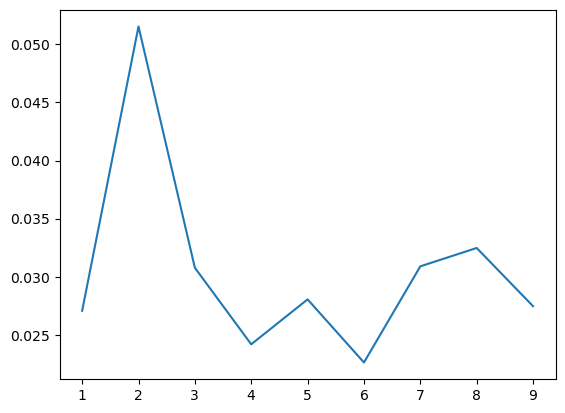

The most accurate test size is 0.6


In [29]:
df_np = df.to_numpy()
X = df.iloc[:, 2:39]
X = np.asarray(X)
y = np.asarray(df["price"])
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
y = y.reshape(-1, 1)
scaler.fit(y)
y = scaler.transform(y)
#y = tf.keras.utils.to_categorical(y, 3)
scores =[]
for n in range(1, 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

    #ANN architecture
    mse_regression_accuracy = tf.keras.metrics.MeanSquaredError()

    model = tf.keras.models.Sequential()
    model.add(keras.layers.Dense(256, 
                                    input_shape=(36,), 
                                    name='Hidden_Layer_1', 
                                    activation='relu'))
    model.add(keras.layers.Dense(256, 
                                    name='Hidden_Layer_2', 
                                    activation='relu'))
    model.add(keras.layers.Dense(1, 
                                    input_shape=(1,), 
                                    name='OUTPUT', 
                                    activation='linear'))
    model.compile(loss='mse')#,
        #metrics=[mse_regression_accuracy])

    model_history=model.fit(X_train, y_train, 
                            batch_size=32,
                            epochs=80,
                            verbose=0,
                            validation_split=0.2)
    
    #z = pandas.DataFrame(model_history.history)["val_mean_squared_error"]
    #z.plot(figsize=(8, 6))
    #plt.title("Accuracy Improvements As Model Learned")
    #plt.show()
    score = model.evaluate(X_test, y_test)  
    scores.append(score)
idx = min(scores)
idx = scores.index(idx)

scoreplot_y = pandas.Series(scores)
scoreplot_x = pandas.Series(range(1, 10, 1))
plt.plot(scoreplot_x.values, scoreplot_y.values)
plt.show()
print(f"The most accurate test size is 0.{idx +1}") 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 1ms/step - loss: 0.0253


0.025281758978962898

4/4 [==============================] - 0s 997us/step


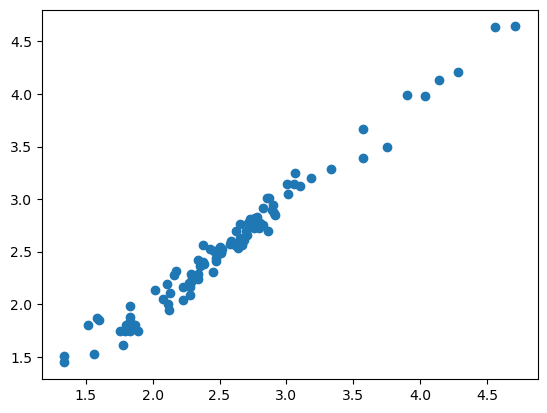

In [31]:
yhat = model.predict(X_test)
yhat = scaler.inverse_transform(yhat)
y_test = scaler.inverse_transform(y_test)
plt.scatter(yhat, y_test)

The model's struggles around the high and low end of the price range are evident from the above graph.